---
title: Mandelbrot in Mojo with Python plots
description: Learn how to write high-performance Mojo code and import Python packages.
website:
  open-graph:
    image: /static/images/mojo-social-card.png
  twitter-card:
    image: /static/images/mojo-social-card.png
---

*Copyright 2023 Modular, Inc: Licensed under the Apache License v2.0 with LLVM Exceptions.*

# Mandelbrot in Mojo with Python plots

Not only is Mojo great for writing high-performance code, but it also allows us to leverage the huge Python ecosystem of libraries and tools. With seamless Python interoperability, Mojo can use Python for what it's good at, especially GUIs, without sacrificing performance in critical code. Let's take the classic Mandelbrot set algorithm and implement it in Mojo.

This tutorial shows two aspects of Mojo. First, it shows that Mojo can be used to develop fast programs for irregular applications. It also shows how we can leverage Python for visualizing the results.

In [1]:
#|code-fold: true
from benchmark import Benchmark
from complex import ComplexSIMD, ComplexFloat64
from math import iota
from python import Python
from runtime.llcl import num_cores, Runtime
from algorithm import parallelize, vectorize
from tensor import Tensor
from utils.index import Index

alias float_type = DType.float64
alias simd_width = simdwidthof[float_type]()

First set some parameters, you can try changing these to see different results:

In [2]:
alias width = 960
alias height = 960
alias MAX_ITERS = 200

alias min_x = -2.0
alias max_x = 0.6
alias min_y = -1.5
alias max_y = 1.5

The core [Mandelbrot](https://en.wikipedia.org/wiki/Mandelbrot_set) algorithm involves computing an iterative complex function for each pixel until it "escapes" the complex circle of radius 2, counting the number of iterations to escape:

$$z_{i+1} = z_i^2 + c$$

In [3]:
# Compute the number of steps to escape.
def mandelbrot_kernel(c: ComplexFloat64) -> Int:
    z = c
    for i in range(MAX_ITERS):
        z = z * z + c
        if z.squared_norm() > 4:
            return i
    return MAX_ITERS


def compute_mandelbrot() -> Tensor[float_type]:
    # create a matrix. Each element of the matrix corresponds to a pixel
    t = Tensor[float_type](height, width)

    dx = (max_x - min_x) / width
    dy = (max_y - min_y) / height

    y = min_y
    for row in range(height):
        x = min_x
        for col in range(width):
            t[Index(row, col)] = mandelbrot_kernel(ComplexFloat64(x, y))
            x += dx
        y += dy
    return t

Plotting the number of iterations to escape with some color gives us the canonical Mandelbrot set plot. To render it we can directly leverage Python's `matplotlib` right from Mojo!

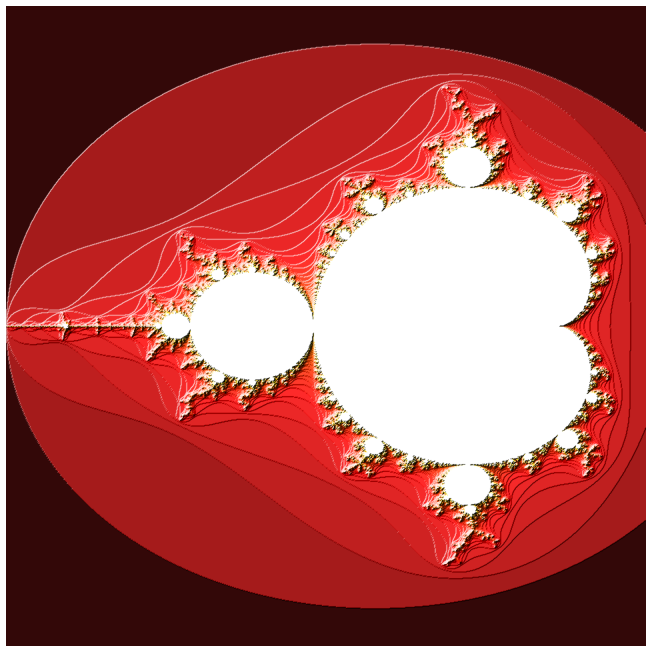

In [4]:
def show_plot(tensor: Tensor[float_type]):
    alias scale = 10
    alias dpi = 64

    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")
    colors = Python.import_module("matplotlib.colors")

    numpy_array = np.zeros((height, width), np.float64)

    for row in range(height):
        for col in range(width):
            numpy_array.itemset((col, row), tensor[col, row])

    fig = plt.figure(1, [scale, scale * height // width], dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)
    light = colors.LightSource(315, 10, 0, 1, 1, 0)

    image = light.shade(numpy_array, plt.cm.hot, colors.PowerNorm(0.3), "hsv", 0, 0, 1.5)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

show_plot(compute_mandelbrot())

## Vectorizing Mandelbrot
We showed a naive implementation of the Mandelbrot algorithm, but there are two things we can do to speed it up. We can early-stop the loop iteration when a pixel is known to have escaped, and we can leverage Mojo's access to hardware by vectorizing the loop, computing multiple pixels simultaneously. To do that we will use the `vectorize` higher order generator.

We start by defining our main iteration loop in a vectorized fashion

In [5]:
fn mandelbrot_kernel_SIMD[
    simd_width: Int
](c: ComplexSIMD[float_type, simd_width]) -> SIMD[float_type, simd_width]:
    """A vectorized implementation of the inner mandelbrot computation."""
    var z = ComplexSIMD[float_type, simd_width](0, 0)
    var iters = SIMD[float_type, simd_width](0)

    var in_set_mask: SIMD[DType.bool, simd_width] = True
    for i in range(MAX_ITERS):
        if not in_set_mask.reduce_or():
            break
        in_set_mask = z.squared_norm() <= 4
        iters = in_set_mask.select(iters + 1, iters)
        z = z.squared_add(c)

    return iters

The above function is parameterized on the `simd_width` and processes simd_width pixels. It only escapes once all pixels within the vector lane are done. We can use the same iteration loop as above, but this time we vectorize within each row instead. We use the `vectorize` generator to make this a simple function call.

Vectorized : 21.376953 ms


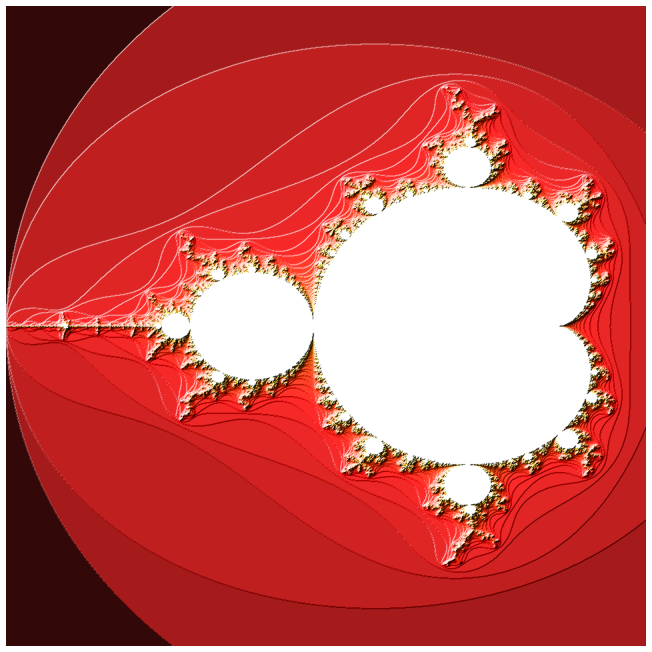

In [6]:
fn vectorized():
    let t = Tensor[float_type](height, width)

    @parameter
    fn worker(row: Int):
        let scale_x = (max_x - min_x) / width
        let scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we oeprate on a `simd_width` vector of pixels."""
            let cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            let cy = min_y + row * scale_y
            let c = ComplexSIMD[float_type, simd_width](cx, cy)
            t.data().simd_store[simd_width](row * width + col, mandelbrot_kernel_SIMD[simd_width](c))

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[simd_width, compute_vector](width)

    
    @parameter
    fn bench[simd_width: Int]():
        for row in range(height):
            worker(row)

    let vectorized = Benchmark().run[bench[simd_width]]() / 1e6
    print("Vectorized", ":", vectorized, "ms")

    try:
        _ = show_plot(t)
    except e:
        print("failed to show plot:", e.value)

vectorized()

## Parallelizing Mandelbrot
While the vectorized implementation above is efficient, we can get better performance by parallelizing on the cols. This again is simple in Mojo using the `parallelize` higher order function. Only the function that performs the invocation needs to change.

Parallelized: 0.97671799999999998 ms


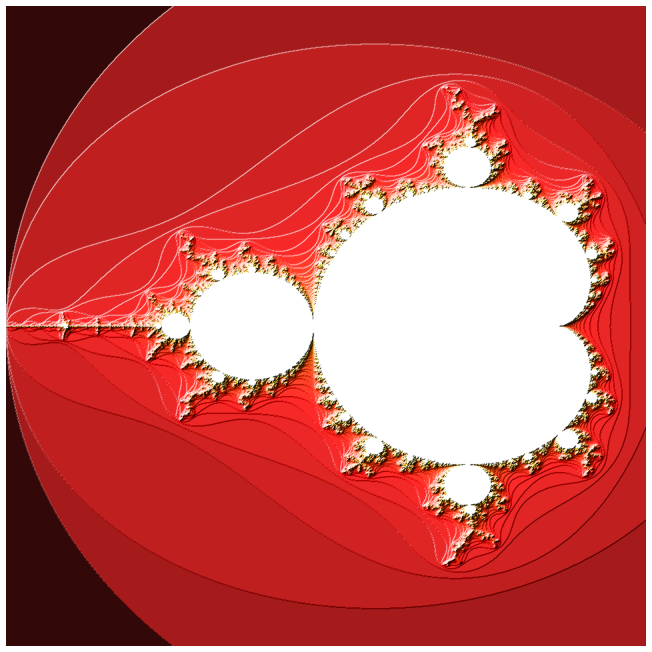

In [7]:
fn parallelized():
    let t = Tensor[float_type](height, width)

    @parameter
    fn worker(row: Int):
        let scale_x = (max_x - min_x) / width
        let scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we oeprate on a `simd_width` vector of pixels."""
            let cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            let cy = min_y + row * scale_y
            let c = ComplexSIMD[float_type, simd_width](cx, cy)
            t.data().simd_store[simd_width](row * width + col, mandelbrot_kernel_SIMD[simd_width](c))

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[simd_width, compute_vector](width)

    
    with Runtime() as rt:
        @parameter
        fn bench_parallel[simd_width: Int]():
            parallelize[worker](rt, height, 5 * num_cores())

        alias simd_width = simdwidthof[DType.float64]()
        let parallelized = Benchmark().run[bench_parallel[simd_width]]() / 1e6
        print("Parallelized:", parallelized, "ms")

    try:
        _ = show_plot(t)
    except e:
        print("failed to show plot:", e.value)

parallelized()

## Benchmarking

In this section we benchmark our sequential implementation against the parallel implementation. As you see, it is a significant speedup. To get more pronounced speedups, try adjusting MAX_ITERS (e.g. 1000 or 10000) and/or the image size to (e.g. to 4096x4096).

In [8]:
fn compare():
    let t = Tensor[float_type](height, width)

    @parameter
    fn worker(row: Int):
        let scale_x = (max_x - min_x) / width
        let scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we oeprate on a `simd_width` vector of pixels."""
            let cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            let cy = min_y + row * scale_y
            let c = ComplexSIMD[float_type, simd_width](cx, cy)
            t.data().simd_store[simd_width](row * width + col, mandelbrot_kernel_SIMD[simd_width](c))

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[simd_width, compute_vector](width)

    
    @parameter
    fn bench[simd_width: Int]():
        for row in range(height):
            worker(row)

    let vectorized = Benchmark().run[bench[simd_width]]() / 1e6
    print("Number of hardware cores:", num_cores())
    print("Vectorized:", vectorized, "ms")

    # Parallelized
    with Runtime() as rt:
        @parameter
        fn bench_parallel[simd_width: Int]():
            parallelize[worker](rt, height, 5 * num_cores())

        alias simd_width = simdwidthof[DType.float64]()
        let parallelized = Benchmark().run[bench_parallel[simd_width]]() / 1e6
        print("Parallelized:", parallelized, "ms")
        print("Parallel speedup:", vectorized / parallelized)

    _ = t # Make sure tensor isn't destroyed before benchmark is finished

In [11]:
#| CHECK: speedup
compare()

Number of hardware cores: 32
Vectorized: 20.585426999999999 ms
Parallelized: 0.95624200000000004 ms
Parallel speedup: 21.527424020279383
